In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

# import plotly.express as px

In [2]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')
df.head(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,13-03-2014,68,28,...,20,1,0,0,0,0,0,3,11,0


# **Data Cleaning and Transformation**

In [3]:
# Select the desired features
df_new = df.copy()
df_new = df_new[['ID','Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds']]

Drop NAs

In [4]:
df_new = df_new.dropna()

## Transformation

In [5]:
# Add a column of number of days
df_new['Dt_Customer'] = pd.to_datetime(df_new['Dt_Customer'], format='%d-%m-%Y')

aux = max(df_new['Dt_Customer'])
reference_date =pd.to_datetime(aux,format='%d-%m-%Y')

# Total amount spent by costumer
df_new['MntTotal'] = df_new[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)

education_replace = {'Basic':'Undergraduate','2n Cycle':'Undergraduate','Graduation':'Graduate','Master':'Postgraduate','PhD':'Postgraduate'}
df_new['Education'] = df_new['Education'].replace(education_replace)

# Reference year
reference_year = reference_date
reference_year = pd.to_datetime(reference_year,format='%d-%m-%Y')
reference_year = reference_year.year

# Age column
df_new['Age'] = reference_year - df_new['Year_Birth']

# Total children at household
df_new['Total_Children'] = df_new['Kidhome'] + df_new['Teenhome']

# Extract living situation
category_replace = {'Married':'Partner', 'Together':'Partner', 'Absurd':'Alone', 'Widow':'Alone', 'YOLO':'Alone', 'Divorced':'Alone', 'Single':'Alone'}
df_new['Living_Status'] = df_new['Marital_Status'].replace(category_replace)

# Total amount of people
df_new['Members_Household'] = df_new['Living_Status'].replace({'Alone': 1, 'Partner':2})+ df_new['Total_Children']

# Calculate days since signup
df_new['Days_Enrolment'] = (reference_date - df_new['Dt_Customer']).dt.days

print("The newest customer's enrolment date in therecords:",max(df_new['Days_Enrolment']))
print("The oldest customer's enrolment date in the records:",min(df_new['Days_Enrolment']))

# Drop the unused columns
df_new.drop(["ID","Kidhome","Teenhome","Marital_Status","Dt_Customer","Year_Birth"],axis=1,inplace=True)

The newest customer's enrolment date in therecords: 699
The oldest customer's enrolment date in the records: 0


C:\Users\alvar\AppData\Local\Temp\ipykernel_22900\3513805544.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_new['Members_Household'] = df_new['Living_Status'].replace({'Alone': 1, 'Partner':2})+ df_new['Total_Children']


In [6]:
df_new

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,MntTotal,Age,Total_Children,Living_Status,Members_Household,Days_Enrolment
0,Graduate,58138.0,58,635,88,546,172,88,88,1617,57,0,Alone,1,663
1,Graduate,46344.0,38,11,1,6,2,1,6,27,60,2,Alone,3,113
2,Graduate,71613.0,26,426,49,127,111,21,42,776,49,0,Partner,2,312
3,Graduate,26646.0,26,11,4,20,10,3,5,53,30,1,Partner,3,139
4,Postgraduate,58293.0,94,173,43,118,46,27,15,422,33,1,Partner,3,161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,Graduate,61223.0,46,709,43,182,42,118,247,1341,47,1,Partner,3,381
2236,Postgraduate,64014.0,56,406,0,30,0,0,8,444,68,3,Partner,5,19
2237,Graduate,56981.0,91,908,48,217,32,12,24,1241,33,0,Alone,1,155
2238,Postgraduate,69245.0,8,428,30,214,80,30,61,843,58,1,Partner,3,156


## **Outliers**

In [ ]:
LogisticRegression(C =)
# get rid of outliers in age
df_new = df_new[df_new['Age']<100]

## **Categorical Variables - onehot encoder**

In [8]:
categorical_columns = df_new.select_dtypes(include=['object']).columns.tolist()

encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(df_new[categorical_columns])

ne_hot_encoded = encoder.fit_transform(df_new[categorical_columns])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Reset index before concatenation to avoid NaN issues
df_new = df_new.reset_index(drop=True)
encoded_df = one_hot_df.reset_index(drop=True)

df_encoded = pd.concat([df_new, encoded_df], axis=1)

df_encoded = df_encoded.drop(categorical_columns, axis=1)

# Dropped Living_Status_Partner because its the opposite of Living_Status_Alone
df_encoded.drop(["Living_Status_Partner"], axis=1, inplace=True)

In [9]:
df_encoded

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,MntTotal,Age,Total_Children,Members_Household,Days_Enrolment,Education_Graduate,Education_Postgraduate,Education_Undergraduate,Living_Status_Alone
0,58138.0,58,635,88,546,172,88,88,1617,57,0,1,663,1.0,0.0,0.0,1.0
1,46344.0,38,11,1,6,2,1,6,27,60,2,3,113,1.0,0.0,0.0,1.0
2,71613.0,26,426,49,127,111,21,42,776,49,0,2,312,1.0,0.0,0.0,0.0
3,26646.0,26,11,4,20,10,3,5,53,30,1,3,139,1.0,0.0,0.0,0.0
4,58293.0,94,173,43,118,46,27,15,422,33,1,3,161,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2208,61223.0,46,709,43,182,42,118,247,1341,47,1,3,381,1.0,0.0,0.0,0.0
2209,64014.0,56,406,0,30,0,0,8,444,68,3,5,19,0.0,1.0,0.0,0.0
2210,56981.0,91,908,48,217,32,12,24,1241,33,0,1,155,1.0,0.0,0.0,1.0
2211,69245.0,8,428,30,214,80,30,61,843,58,1,3,156,0.0,1.0,0.0,0.0


# **EXERCISE 1. Regression: part a**

## **Data for regression**

- **Regressors**: Income, Recency, Age, Total_Children, Members_Household, Days_Enrolment, Education_Graduate, Education_Postgraduate, Education_Undergraduate, Living_Status_Alone, MntFruits, MntMeat, MntFish

- **Target**: Mnt_Total



In [29]:
X = df_encoded[['Income','Recency', 'Age', 'Total_Children', 'Members_Household', 'Days_Enrolment', 'Education_Graduate', 'Education_Postgraduate', 'Education_Undergraduate', 'Living_Status_Alone', 'MntFruits','MntMeatProducts','MntFishProducts']]
y = df_encoded['MntTotal']

[n,p] = X.shape
print(f'Number of samples: {n}')
print(f'Number of features: {p}')

Number of samples: 2213
Number of features: 13


a) Selected features for regression analysis:

*Maybe we can change some of these.*

**Continuous Variables**:
- Income
- Recency
- Age
- Total_Children
- Members_Household
- Days_Enrolment
- MntFruits
- MntMeatProducts
- MntFishProducts

**Categorical Variables** (one-hot encoded):
- Education_Graduate
- Education_Postgraduate
- Education_Undergraduate
- Living_Status_Alone

Target Variable:
- MntTotal (total amount spent by customer)

## **Ridge Regression**

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error

In [30]:
# Define a range of lambda (alpha) values to test
lambda_values = np.logspace(-1,3, 100)

# Initialize scaler (standardization)
scaler = StandardScaler()

# Define a pipeline that includes normalization and regression to indtroduce in the GridSearchCV
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('ridge', Ridge())             # Apply Ridge Regression
])

# We need a dictionary as an input for the parameters
param_lambda_values = {'ridge__alpha' : lambda_values}

# Perform GridSearchCV to find the best lambda (alpha in this case)
# Its basically a tool to tune/optimize a hyperparamter (lambda in this case)
# its neg_mse beacuse we want to MINIMIZE the score mse (gridsearch always maximizes the score)
ridge_cv = GridSearchCV(estimator=ridge_pipeline,
                        param_grid=param_lambda_values,
                        scoring='neg_mean_squared_error',
                        cv=10) # we obtain min RMSE with 5 folds
ridge_cv.fit(X, y)  # it is using the normalized data stablished in the pipeline

# Get the best lambda
best_lambda_ridge = ridge_cv.best_params_['ridge__alpha']

# Get the best RMSE
ridge_rmse = np.sqrt(-ridge_cv.best_score_)

# Apply one standard error rule
cv_results = ridge_cv.cv_results_
mean_scores = -cv_results['mean_test_score']  # Convert back to MSE
std_scores = cv_results['std_test_score']

# Parameters
print(f"Best lambda: {ridge_cv.best_params_['ridge__alpha']:.4f} \nGeneralization Error (RMSE): {ridge_rmse:.4f}")

Best lambda: 247.7076 
Generalization Error (RMSE): 283.2651


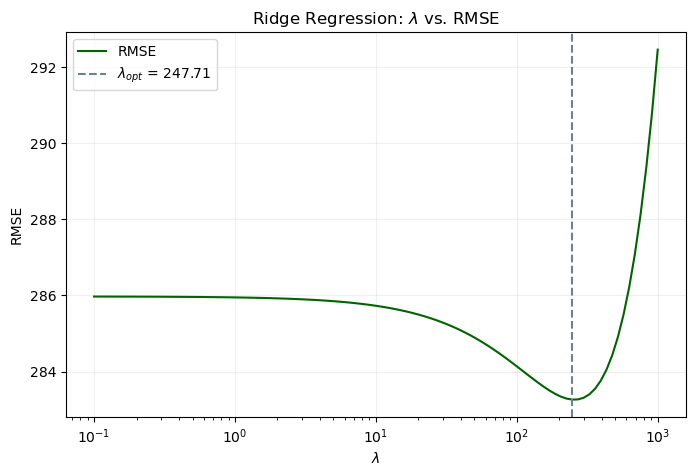

In [31]:
mse_scores = -ridge_cv.cv_results_['mean_test_score']
rmse_scores = np.sqrt(mse_scores)

plt.figure(figsize=(8, 5))
plt.plot(lambda_values, rmse_scores, color='darkgreen', linestyle='-', label='RMSE')
# Mark the best lambda
plt.axvline(best_lambda_ridge, color='slategray', linestyle='--', 
            label=rf'$\lambda_{{opt}}$ = {best_lambda_ridge:.2f}')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel(r"$\lambda$")
plt.ylabel("RMSE")
plt.title(r"Ridge Regression: $\lambda$ vs. RMSE")
plt.legend()
plt.grid(alpha=.2)
plt.show()

The Ridge Regression plot demonstrates the relationship between the regularization parameter λ and model generalization error measured by RMSE. The optimal λ value (613.59), achieves the lowest RMSE, representing the best balance between model complexity and prediction accuracy. Beyond this point, RMSE increases sharply, suggesting that excessive regularization leads to underfitting.

In [32]:
# Coefficients
coef = ridge_cv.best_estimator_.named_steps['ridge'].coef_
print(f"\nCoefficients: {coef}")


Coefficients: [129.08137543   6.21238336  29.09796816 -35.95873315 -23.50131698
  55.72232741 -10.70047853  25.94104369 -22.83303191 -11.80995369
  78.70049551 271.80131395  92.84789701]


c) 

## Model
The total amount spent (y) is computed as a weighted sum of customer attributes (x):


y = 264.03(Income) + 11.27(Recency) + 31.30(Age) - 122.34(Total_Children) 
    - 84.47(Members_Household) + 75.77(Days_Enrolment) + 4.37(Education_Graduate) 
    + 12.46(Education_Postgraduate) - 25.93(Education_Undergraduate) 
    - 31.62(Living_Status_Alone)


## Impact of Individual Attributes

### Strong Positive Influences
- **Income** (264.03): Strongest predictor of spending
- **Days_Enrolment** (75.77): Customer loyalty correlates with higher spending
- **Age** (31.30): Positive relationship with spending

### Strong Negative Influences
- **Total_Children** (-122.34): More children correlates with lower spending
- **Members_Household** (-84.47): Larger households spend less
- **Living_Status_Alone** (-31.62): Single status predicts lower spending

### Education Level Impact
- **Postgraduate** (12.46): Highest spending among education levels
- **Graduate** (4.37): Slight positive effect
- **Undergraduate** (-25.93): Negative effect

The coefficients align with expected consumer behavior:
- Income as the strongest predictor makes sense
- Loyal customers spending more matches retail patterns
- Family size's negative impact MAYBE suggests budget constraints
- Education level correlation with spending follows socioeconomic patterns

# **EXERCISE 3: Classification**

## **Data for classification**

For example, we can predict the variable Education, since it is practically the only categorical one that is not binary. Of course, we can change the target variable.

- **Variables**: Income, Recency, Age, Total_Children, Members_Household, Days_Enrolment, Living_Status_Alone, MntTotal

- **Target**: Education (Undergraduate, Graduate, Postgraduate)



In [15]:
# Establish Family Size
df_encoded['FamilySize'] = ['Large' if members >= 3 else 'Small' for members in df_encoded['Members_Household']]
X = df_encoded[['Income','Recency', 'Age', 'Days_Enrolment', 'Education_Graduate', 'Education_Postgraduate', 'Education_Undergraduate','MntFruits','MntMeatProducts','MntFishProducts', 'MntTotal']]

# Target Variable
y = df_encoded['FamilySize']

[n,p] = X.shape
print(f'Number of samples: {n}')
print(f'Number of features: {p}')

Number of samples: 2213
Number of features: 11


## **Model 1: KNN**

Here, we optimize the number of neighbors (k).

In [16]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

In [17]:
# Encode the target variable (Education)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Print class mapping
print("\nClass mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"{i}: {class_name}")

# Define a range of lambda (alpha) values to test
k_values = np.arange(3,31,2)

# Initialize scaler (standardization)
scaler = StandardScaler()

# Define a pipeline that includes normalization and regression to indtroduce in the GridSearchCV
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('knn', KNeighborsClassifier())             # Apply KNN
])

# We need a dictionary as an input for the parameters
param_k_values = {'knn__n_neighbors' : k_values}

# Perform GridSearchCV to find the best lambda (alpha in this case)
# Its basically a tool to tune/optimize a hyperparamter (lambda in this case)
# its neg_mse beacuse we want to MINIMIZE the score mse (gridsearch always maximizes the score)
knn_cv = GridSearchCV(estimator=knn_pipeline,
                        param_grid=param_k_values,
                        scoring='accuracy',
                        cv=10) # we obtain min RMSE with cv folds
knn_cv.fit(X, y)  # it is using the normalized data stablished in the pipeline

# Get the best k
best_k = knn_cv.best_params_['knn__n_neighbors']

# Get the best accuracy
best_accuracy = knn_cv.best_score_

# Print results
print(f"Best k: {best_k}")
print(f"Best accuracy for KNN is: {best_accuracy:.4f}")


Class mapping:
0: Large
1: Small
Best k: 27
Best accuracy for KNN is: 0.7027


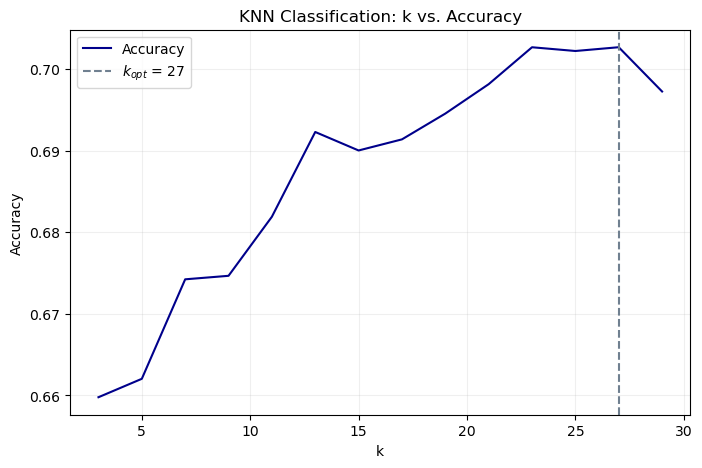

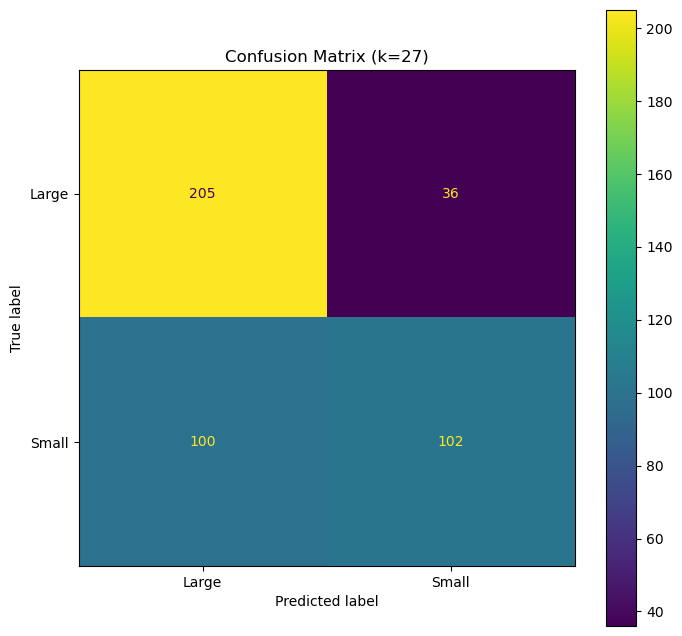

In [18]:
# Get cross-validation results
cv_results = knn_cv.cv_results_
mean_scores = cv_results['mean_test_score']
std_scores = cv_results['std_test_score']

# Plot the cross-validation results
plt.figure(figsize=(8, 5))
plt.plot(k_values, mean_scores, color='darkblue', linestyle='-', label='Accuracy')
# Mark the best k
plt.axvline(best_k, color='slategray', linestyle='--', 
            label=f'$k_{{opt}}$ = {best_k}')
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("KNN Classification: k vs. Accuracy")
plt.legend()
plt.grid(alpha=.2)
plt.show()

# Get the confusion matrix for the best model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the best model
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(scaler.fit_transform(X_train), y_train)

# Predict
y_pred = best_knn.predict(scaler.transform(X_test))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.title(f"Confusion Matrix (k={best_k})")
plt.show()



## **Model 2: Logistic Regression (Multinomial)**

In [19]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [20]:
# Encode the target variable (Education)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Print class mapping
print("\nClass mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"{i}: {class_name}")

# Define a range of C values to test (C = 1/lambda)
# Smaller C means stronger regularization
C_values = np.logspace(-3, 3, 30)

# Initialize scaler (standardization)
scaler = StandardScaler()

# Define a pipeline that includes normalization and multinomial regression
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('logreg', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))  # Apply Logistic (Multinomial) Regression
])

# Parameter grid for GridSearchCV
param_C_values = {'logreg__C': C_values}

# Perform GridSearchCV to find the best C (inverse of lambda)
logreg_cv = GridSearchCV(estimator=logreg_pipeline,
                        param_grid=param_C_values,
                        scoring='accuracy',
                        cv=10)  # 10-fold cross-validation
logreg_cv.fit(X, y_encoded)

# Get the best C
best_C = logreg_cv.best_params_['logreg__C']
best_lambda = 1/best_C  # Convert to lambda for reporting

# Get the best accuracy
best_accuracy = logreg_cv.best_score_

# Print results
print(f"\nBest C: {best_C:.4f} (lambda = {best_lambda:.4f})")
print(f"Best accuracy for Logistic (Multinomial) Regression is: {best_accuracy:.4f}")


Class mapping:
0: Large
1: Small


c:\Users\alvar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\alvar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\alvar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_clas


Best C: 0.0026 (lambda = 385.6620)
Best accuracy for Logistic (Multinomial) Regression is: 0.6977


c:\Users\alvar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\alvar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\alvar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_clas

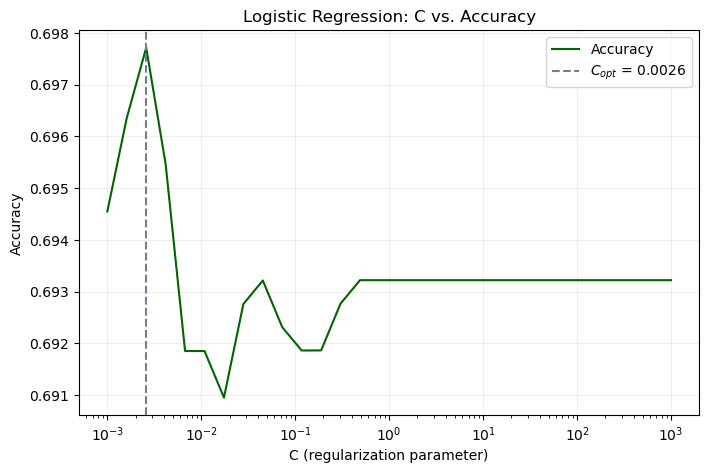

c:\Users\alvar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


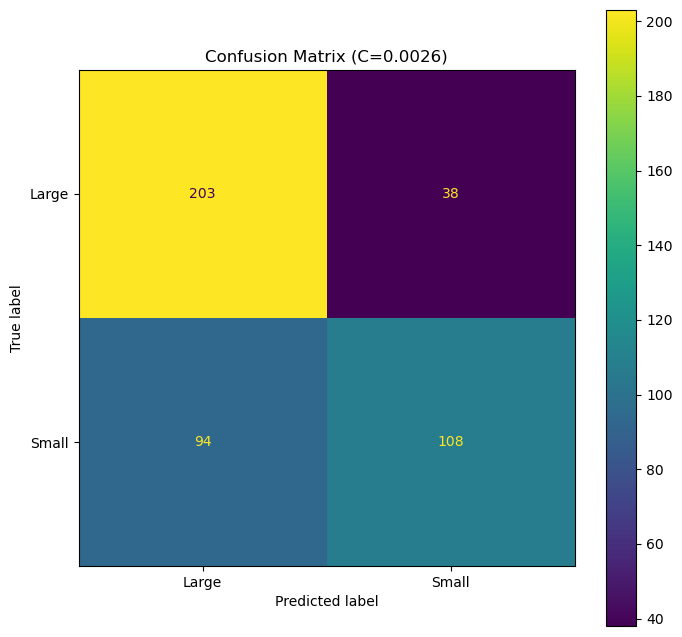

In [21]:
# Get cross-validation results
cv_results = logreg_cv.cv_results_
mean_scores = cv_results['mean_test_score']
std_scores = cv_results['std_test_score']

# Plot the cross-validation results
plt.figure(figsize=(8, 5))
plt.semilogx(C_values, mean_scores, color='darkgreen', linestyle='-', label='Accuracy')
# Mark the best C
plt.axvline(best_C, color='slategray', linestyle='--', 
            label=f'$C_{{opt}}$ = {best_C:.4f}')
plt.xlabel("C (regularization parameter)")
plt.ylabel("Accuracy")
plt.title("Logistic Regression: C vs. Accuracy")
plt.legend()
plt.grid(alpha=.2)
plt.show()

# Get the confusion matrix for the best model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the best model
best_logreg = LogisticRegression(C=best_C, multi_class='multinomial', solver='lbfgs', max_iter=1000)
best_logreg.fit(scaler.fit_transform(X_train), y_train)

# Predict
y_pred_logreg = best_logreg.predict(scaler.transform(X_test))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.title(f"Confusion Matrix (C={best_C:.4f})")
plt.show()

## **Model 3: Baseline**

Baseline model accuracy: 0.5440

Class mapping:
0: Large
1: Small


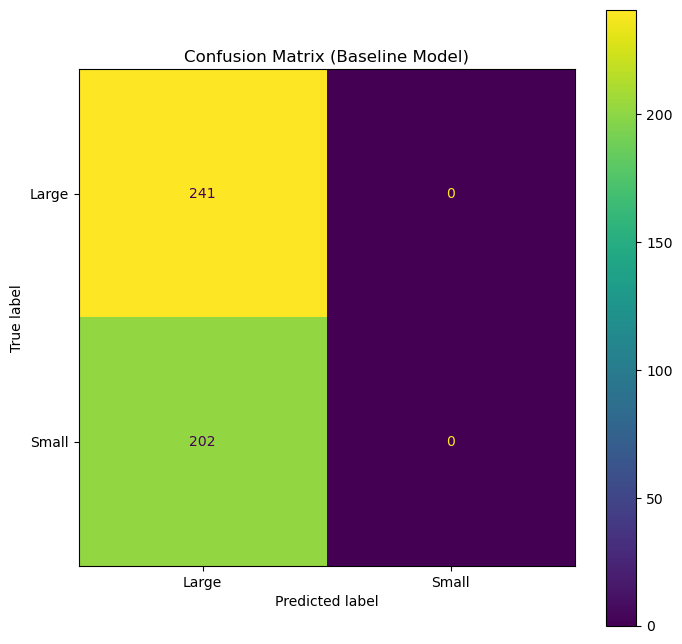

In [22]:
# Create a baseline model (predicts the most frequent class)
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode the target variable (Education)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data for evaluation
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Create and train the baseline model
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train_encoded)

# Predict
y_pred_baseline = baseline.predict(X_test)

# Calculate accuracy
baseline_accuracy = baseline.score(X_test, y_test_encoded)
print(f"Baseline model accuracy: {baseline_accuracy:.4f}")

# Print class mapping
print("\nClass mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"{i}: {class_name}")

# Plot confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.title("Confusion Matrix (Baseline Model)")
plt.show()

## **Model 4: Classification Trees (CT)**

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Encode the target variable (Education)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Print class mapping
print("\nClass mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"{i}: {class_name}")

# Define a range of max_depth values to test
depth_values = np.arange(1, 20)  # Testing depths from 1 to 19

# Initialize scaler (standardization)
scaler = StandardScaler()

# Define a pipeline that includes normalization and decision tree
tree_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('tree', DecisionTreeClassifier())  # Apply Decision Tree
])

# Parameter grid for GridSearchCV
param_depth_values = {'tree__max_depth': depth_values}

# Perform GridSearchCV to find the best max_depth
tree_cv = GridSearchCV(estimator=tree_pipeline,
                      param_grid=param_depth_values,
                      scoring='accuracy',
                      cv=10)  # 10-fold cross-validation
tree_cv.fit(X, y_encoded)

# Get the best max_depth
best_depth = tree_cv.best_params_['tree__max_depth']

# Get the best accuracy
best_accuracy = tree_cv.best_score_

# Print results
print(f"\nBest max_depth: {best_depth}")
print(f"Best accuracy for Classification Trees: {best_accuracy:.4f}")


Class mapping:
0: Large
1: Small

Best max_depth: 13
Best accuracy for Classification Trees: 0.7171


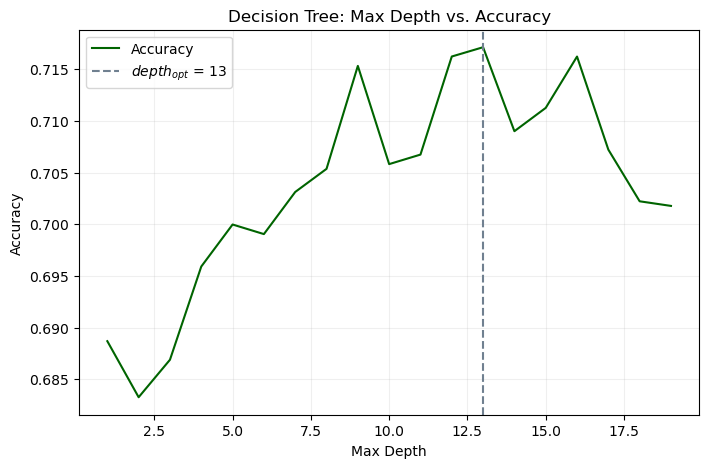

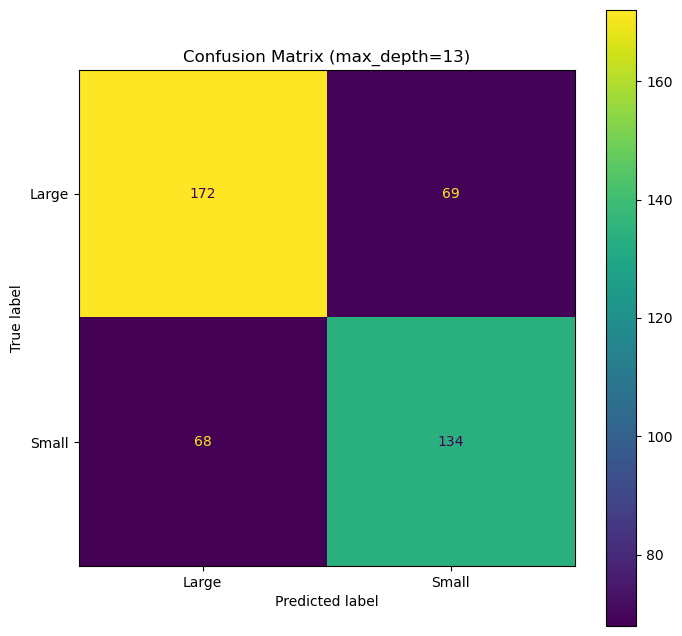

In [24]:
# Get cross-validation results
cv_results = tree_cv.cv_results_
mean_scores = cv_results['mean_test_score']
std_scores = cv_results['std_test_score']

# Plot the cross-validation results
plt.figure(figsize=(8, 5))
plt.plot(depth_values, mean_scores, color='darkgreen', linestyle='-', label='Accuracy')
# Mark the best depth
plt.axvline(best_depth, color='slategray', linestyle='--', 
            label=f'$depth_{{opt}}$ = {best_depth}')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree: Max Depth vs. Accuracy")
plt.legend()
plt.grid(alpha=.2)
plt.show()

# Get the confusion matrix for the best model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the best model
best_tree = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
best_tree.fit(scaler.fit_transform(X_train), y_train)

# Predict
y_pred_tree = best_tree.predict(scaler.transform(X_test))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_tree, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.title(f"Confusion Matrix (max_depth={best_depth})")
plt.show()

# Calculate and plot feature importance
feature_importance = best_tree.feature_importances_
feature_names = X.columns

# Sort features by importance
indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[indices]
sorted_features = [feature_names[i] for i in indices]

## **Model 5: ANN**

In [25]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import LabelEncoder

# # Encode the target variable (Education)
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# # Print class mapping
# print("\nClass mapping:")
# for i, class_name in enumerate(le.classes_):
#     print(f"{i}: {class_name}")

# # Define a range of hidden units to test
# hidden_units = np.arange(1, 21)  # Testing from 1 to 20 hidden units
# hidden_layer_sizes = [(h,) for h in hidden_units]  # Create tuples for hidden_layer_sizes parameter

# # Initialize scaler (standardization)
# scaler = StandardScaler()

# # Define a pipeline that includes normalization and neural network
# ann_pipeline = Pipeline([
#     ('scaler', StandardScaler()),  # Standardize features
#     ('ann', MLPClassifier(activation='relu', solver='adam', max_iter=1000))  # Apply Neural Network
# ])

# # Parameter grid for GridSearchCV
# param_hidden_units = {'ann__hidden_layer_sizes': hidden_layer_sizes}

# # Perform GridSearchCV to find the best number of hidden units
# ann_cv = GridSearchCV(estimator=ann_pipeline,
#                      param_grid=param_hidden_units,
#                      scoring='accuracy',
#                      cv=10)  # 10-fold cross-validation
# ann_cv.fit(X, y_encoded)

# # Get the best number of hidden units
# best_hidden_units = ann_cv.best_params_['ann__hidden_layer_sizes'][0]

# # Get the best accuracy
# best_accuracy = ann_cv.best_score_

# # Print results
# print(f"\nBest number of hidden units (h): {best_hidden_units}")
# print(f"Best accuracy for ANN: {best_accuracy:.4f}")

In [26]:
# # Get cross-validation results
# cv_results = ann_cv.cv_results_
# mean_scores = cv_results['mean_test_score']
# std_scores = cv_results['std_test_score']

# # Plot the cross-validation results
# plt.figure(figsize=(8, 5))
# plt.plot(hidden_units, mean_scores, color='darkred', linestyle='-', label='Accuracy')
# # Mark the best number of hidden units
# plt.axvline(best_hidden_units, color='slategray', linestyle='--', 
#             label=f'$h_{{opt}}$ = {best_hidden_units}')
# plt.xlabel("Number of Hidden Units (h)")
# plt.ylabel("Accuracy")
# plt.title("Artificial Neural Network: Hidden Units vs. Accuracy")
# plt.legend()
# plt.grid(alpha=.2)
# plt.show()

# # Get the confusion matrix for the best model
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.model_selection import train_test_split

# # Split data for evaluation
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# # Train the best model
# best_ann = MLPClassifier(hidden_layer_sizes=(best_hidden_units,), 
#                          activation='relu', 
#                          solver='adam', 
#                          max_iter=1000)
# best_ann.fit(scaler.fit_transform(X_train), y_train)

# # Predict
# y_pred = best_ann.predict(scaler.transform(X_test))

# # Plot confusion matrix
# cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
# fig, ax = plt.subplots(figsize=(8, 8))
# disp.plot(ax=ax)
# plt.title(f"Confusion Matrix (h={best_hidden_units})")
# plt.show()

## Two-Level Cross Validation

In [27]:
from sklearn.model_selection import KFold

K_outer, K_inner = 10, 10
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)

results = []

fold_no = 1
for train_idx, test_idx in outer_cv.split(X):

    # Split data into outer training and test sets
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    # ----------------------- Baseline Model ----------------------- #
    baseline = DummyClassifier(strategy='most_frequent')
    baseline.fit(X_train, y_train)
    baseline_pred = baseline.predict(X_test)
    baseline_error = np.mean(baseline_pred != y_test)

    # ---------------- Logistic Regression (inner CV) ---------------- #
    logreg_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=1000, solver='lbfgs'))
    ])
    logreg_param_grid = {'logreg__C': np.logspace(-3, 3, 30)}
    logreg_cv = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=inner_cv, scoring='accuracy')
    logreg_cv.fit(X_train, y_train)

    best_C = logreg_cv.best_params_['logreg__C']
    logreg_best = logreg_cv.best_estimator_
    logreg_pred = logreg_best.predict(X_test)
    logreg_error = np.mean(logreg_pred != y_test)

    # ---------------- Classification Tree (inner CV) ---------------- #
    tree_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('tree', DecisionTreeClassifier())
    ])
    tree_param_grid = {'tree__max_depth': np.arange(1, 20)}
    tree_cv = GridSearchCV(tree_pipeline, tree_param_grid, cv=inner_cv, scoring='accuracy')
    tree_cv.fit(X_train, y_train)

    best_depth = tree_cv.best_params_['tree__max_depth']
    tree_best = tree_cv.best_estimator_
    tree_pred = tree_best.predict(X_test)
    tree_error = np.mean(tree_pred != y_test)

    # ------------------ Record results ------------------ #
    results.append({
        'Fold': fold_no,
        'Baseline Error': baseline_error,
        'LogReg λ* (C)': best_C,
        'LogReg Error': logreg_error,
        'Tree depth*': best_depth,
        'Tree Error': tree_error
    })

    print(f'Fold {fold_no} done.')
    fold_no += 1

results_df = pd.DataFrame(results)
print(results_df)

# The results are disappointing there is no clear winner for neither LogReg or Tree classification

Fold 1 done.
Fold 2 done.
Fold 3 done.
Fold 4 done.
Fold 5 done.
Fold 6 done.
Fold 7 done.
Fold 8 done.
Fold 9 done.
Fold 10 done.
   Fold  Baseline Error  LogReg λ* (C)  LogReg Error  Tree depth*  Tree Error
0     1        0.459459       0.001000      0.319820            8    0.315315
1     2        0.450450       0.001000      0.274775           11    0.261261
2     3        0.454955       0.001610      0.274775           17    0.301802
3     4        0.429864       0.002593      0.285068           16    0.312217
4     5        0.420814       0.001610      0.303167            7    0.298643
5     6        0.484163       0.001000      0.334842            7    0.298643
6     7        0.461538       0.001610      0.266968            5    0.280543
7     8        0.443439       0.002593      0.334842           12    0.343891
8     9        0.438914       0.001000      0.316742           10    0.298643
9    10        0.502262       0.001000      0.343891            9    0.312217


## MCNemars method

In [28]:
from dtuimldmtools import mcnemar
import numpy as np

alpha = 0.05

#Baseline vs Logistic regression
yhat = np.column_stack((baseline_pred, logreg_pred))
[thetahat, CI, p] = mcnemar(y_test, yhat[:, 0], yhat[:, 1], alpha=alpha)
print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p)


#Baseline vs Classification Trees
yhat = np.column_stack((baseline_pred, tree_pred))
[thetahat, CI, p] = mcnemar(y_test, yhat[:, 0], yhat[:, 1], alpha=alpha)
print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p)


#Logistic regression vs Classification Trees
yhat = np.column_stack((logreg_pred, tree_pred))
[thetahat, CI, p] = mcnemar(y_test, yhat[:, 0], yhat[:, 1], alpha=alpha)
print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p)

ModuleNotFoundError: No module named 'dtuimldmtools'